In [1]:
import requests
from match import Match
from read_match_data import parse_match
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# See API documentation for options available: https://docs.football-data.org/general/v4/index.html
league = 'PL' 
seasons = ['2020','2021','2022']

headers = { 
    'X-Auth-Token': '13b41abb78284b7482713f316a0e3578',
           }

In [3]:
matches_list = []
for season in seasons:
    uri = 'https://api.football-data.org/v4/competitions/{}/matches?season={}'.format(league, season)
    response = requests.get(uri, headers=headers)
    matches_dict = parse_match(response.json()['matches'])
    matches_list.extend(matches_dict)

In [4]:
matches = [ Match(d['league'], 
                  d['season_start'],
                  d['season_end'], 
                  d['date'],
                  d['status'],
                  d['matchday'],
                  d['home_team'],
                  d['home_team_short'],
                  d['home_team_code'],
                  d['away_team'],
                  d['away_team_short'],
                  d['away_team_code'],
                  d['home_team_score'],
                  d['away_team_score'],
                  d['home_team_halfscore'],
                  d['away_team_halfscore'],) for d in matches_list ]

In [5]:
len(matches)

1140

In [12]:
last_matches = matches[-3:]
game = 1

team_a = last_matches[game].home_team
team_a_short = last_matches[game].home_team_short
team_b = last_matches[game].away_team
team_b_short = last_matches[game].away_team_short

In [13]:
previous_matches = []
for match in matches:
    if match.home_team == team_a and match.away_team == team_b:
        previous_matches.append(match)
    elif match.home_team == team_b and match.away_team == team_a:
        previous_matches.append(match)

previous_matches

[Match(Matchday:9, home:Aston Villa FC, away:Brighton & Hove Albion FC,1:2, winner:Brighton & Hove Albion FC),
 Match(Matchday:24, home:Brighton & Hove Albion FC, away:Aston Villa FC,0:0, winner:tie),
 Match(Matchday:12, home:Aston Villa FC, away:Brighton & Hove Albion FC,2:0, winner:Aston Villa FC),
 Match(Matchday:27, home:Brighton & Hove Albion FC, away:Aston Villa FC,0:2, winner:Aston Villa FC),
 Match(Matchday:16, home:Brighton & Hove Albion FC, away:Aston Villa FC,1:2, winner:Aston Villa FC),
 Match(Matchday:38, home:Aston Villa FC, away:Brighton & Hove Albion FC,2:1, winner:Aston Villa FC)]

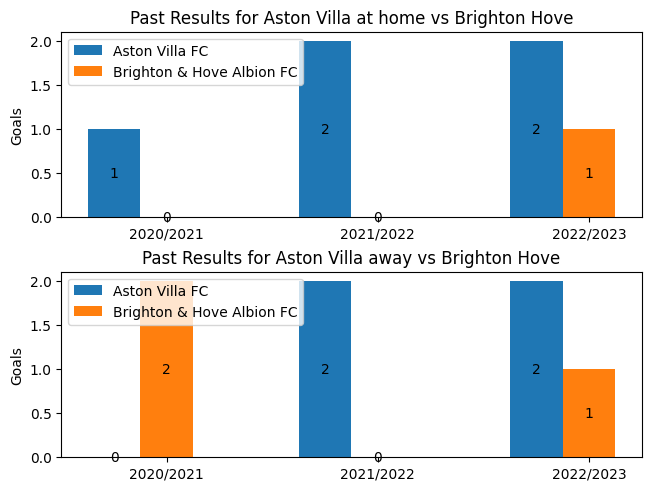

In [14]:
team_a_home_season = [ str(x.season_start.year)+"/"+str(x.season_end.year) for x in previous_matches if x.home_team==team_a ]
team_a_away_season = [ str(x.season_start.year)+"/"+str(x.season_end.year) for x in previous_matches if x.away_team==team_a ]

team_a_home_scores = [ x.home_team_score for x in previous_matches if x.home_team==team_a ]
team_b_away_scores = [ x.away_team_score for x in previous_matches if x.away_team==team_b ]
team_a_away_scores = [ x.away_team_score for x in previous_matches if x.away_team==team_a ]
team_b_home_scores = [ x.home_team_score for x in previous_matches if x.home_team==team_b ]

home_graph = {
    team_a: team_a_home_scores,
    team_b: team_b_home_scores
}
away_graph = {
    team_a: team_a_away_scores,
    team_b: team_b_away_scores
}

fig, (ax1,ax2) = plt.subplots(2,1, layout="constrained")
x = np.arange(len(team_a_home_season))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in home_graph.items():
    offset = width * multiplier
    graph = ax1.bar(x + offset, measurement, width, label=attribute, tick_label=team_a_home_season)
    ax1.bar_label(graph, label_type='center')
    multiplier += 1

x = np.arange(len(team_a_away_season))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in away_graph.items():
    offset = width * multiplier
    graph = ax2.bar(x + offset, measurement, width, label=attribute, tick_label=team_a_away_season)
    ax2.bar_label(graph, label_type='center')
    multiplier += 1

ax1.set_title("Past Results for {} at home vs {}".format(team_a_short, team_b_short))
ax1.set_ylabel("Goals")
ax1.legend(loc='upper left')
ax2.set_title("Past Results for {} away vs {}".format(team_a_short, team_b_short))
ax2.set_ylabel("Goals")
ax2.legend(loc='upper left')

plt.show()